In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define the action space
actions = ['charge', 'idle', 'discharge']

# Modify the get_state function to include the battery capacity
def get_state(price, demand, timestamp, battery_capacity):
    return (price, demand, timestamp, battery_capacity)

In [3]:
# Define battery parameters
max_battery_capacity = 100  # in watt hours
battery_capacity = 100  # in watt hours
charge_discharge_rate = 20 # in watts per 15 minutes
initial_battery_state = battery_capacity / 4  # start with the battery half-charged

timepoints = 24


# Define the demand profile for a regular German private household within a workday

# Define the average consumption for a 15-minute interval in Wh
avg_consumption_15min = (147 + 176) / 2

# Create a list to represent the electricity consumption over 24 hours
consumption_24h = [0]*20 + [avg_consumption_15min]*68 + [0]*8

#print legth of consumption_24h
print(len(consumption_24h))

# Modify the list to reflect that 90% of energy consumption happens between 5 am and 10 pm
consumption_24h_modified = [0.1 * avg_consumption_15min]*20 + [0.9 * avg_consumption_15min]*68 + [0.1 * avg_consumption_15min]*8
# Further modify the list to reflect that energy consumption varies over the day
# Assume that energy consumption is lower (70% of the average) from 9 am to 5 pm when household members are likely to be at school or work
for i in range(16, 64):  # indices corresponding to 9 am to 5 pm
    consumption_24h_modified[i] *= 0.7


# Define a function to add noise to the consumption values
def add_noise(consumption):
    noise = np.random.normal(0, 0.1 * consumption)
    return consumption + noise

# Apply the function to each element in the list
demand_profile = [add_noise(c) for c in consumption_24h_modified]

# print length of demand profile
print(len(demand_profile))



# Define a function to calculate the electricity price based on consumption
def calculate_price(consumption):
    base_price = 0.3  # base price in euros per kWh
    price = base_price + 0.01 * consumption  # price increases with consumption
    return price

# Apply the function to each element in the list
prices_24h = [calculate_price(c) for c in demand_profile]

# Convert the prices from euros per kWh to euros per Wh
electricity_cost = [price / 1000 for price in prices_24h]

# Create a DataFrame with the demand profile and the electricity cost
df = pd.DataFrame({'demand': demand_profile, 'cost': electricity_cost})

# Attach datetime
df['datetime'] = pd.date_range(start='2023-07-05', periods=len(df), freq='15T')

# create new dataframe which is a copy of first 8 rows
df2 = df.iloc[0:timepoints].copy()


96
96


In [4]:
df2

,demand,cost,datetime
0,16.810316,0.000468,2023-07-05 00:00:00
1,16.217308,0.000462,2023-07-05 00:15:00
2,17.554527,0.000476,2023-07-05 00:30:00
3,16.877935,0.000469,2023-07-05 00:45:00
4,14.728983,0.000447,2023-07-05 01:00:00
5,15.499417,0.000455,2023-07-05 01:15:00
6,17.221810,0.000472,2023-07-05 01:30:00
7,17.759289,0.000478,2023-07-05 01:45:00
8,15.772240,0.000458,2023-07-05 02:00:00
9,15.340085,0.000453,2023-07-05 02:15:00


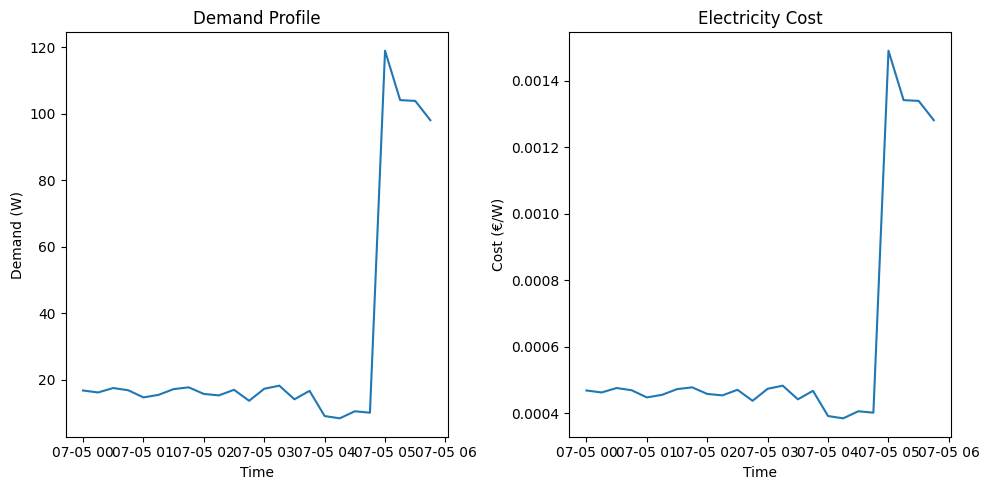

In [5]:
# Plot the demand profile and the electricity cost
plt.figure(figsize=(10, 5))

# Plot the demand profile
plt.subplot(1, 2, 1)
#plt.plot(df['datetime'], df['demand'])
plt.plot(df2['datetime'], df2['demand'])
plt.xlabel('Time')
plt.ylabel('Demand (W)')
plt.title('Demand Profile')

# Plot the electricity cost
plt.subplot(1, 2, 2)
plt.plot(df2['datetime'], df2['cost'])
#plt.plot(df['datetime'], df['cost'])
plt.xlabel('Time')
plt.ylabel('Cost (€/W)')
plt.title('Electricity Cost')

plt.tight_layout()
plt.show()

In [6]:
# Define the new reward function
def get_reward(state, action):
    current_price, current_demand, timestamp, battery_capacity = state

    print('#####')
    print('timestamp: ', timestamp)
    print('battery_capacity: ', battery_capacity)
    print('current_demand: ', current_demand)
    print('current_price: ', current_price)
    print('action: ', action)


    # Calculate the cost with the battery
    if action == 'discharge':
        battery_discharge = min(battery_capacity, current_demand)
        grid_demand = current_demand - battery_discharge

        print('action is battery_discharge: ', battery_discharge)
    elif action == 'charge':
        battery_charge = min(max_battery_capacity - battery_capacity, charge_discharge_rate)
        grid_demand = current_demand + battery_charge
    else:  # action == 'idle'
        grid_demand = current_demand

    cost_with_battery = grid_demand * current_price
    print('cost_with_battery: ', cost_with_battery)
    
    # Calculate the cost without the battery
    cost_without_battery = current_demand * current_price
    print('cost_without_battery: ', cost_without_battery)

    # The reward is the difference in costs
    reward = cost_without_battery - cost_with_battery
    print('reward: ', reward)
    print('#####')
    print("")

    return reward

In [7]:
# Initialize the Q-table to include the battery capacity in terms of watt hours
Q_table = {get_state(price, demand, timestamp, cap): {action: 0 for action in actions} for price in df['cost'] for demand in df['demand'] for timestamp in range(timepoints) for cap in range(0, battery_capacity + 1)}

In [8]:
import random

# Parameters for Q-learning
alpha = 0.5  # learning rate
gamma = 0.9  # discount factor
num_iterations = 100  # number of iterations for exploration

In [9]:
# Define a function for the agent to select the best action in a state
def get_best_action(state):
    return max(Q_table[state], key=Q_table[state].get)

#####
timestamp:  0
battery_capacity:  25.0
current_demand:  16.810316372040244
current_price:  0.0004681031637204024
action:  charge
cost_with_battery:  0.017231025551300964
cost_without_battery:  0.007868962276892915
reward:  -0.009362063274408049
#####

#####
timestamp:  1
battery_capacity:  45.0
current_demand:  16.217307514044332
current_price:  0.0004621730751404433
action:  charge
cost_with_battery:  0.016738664387072954
cost_without_battery:  0.007495202884264088
reward:  -0.009243461502808865
#####

#####
timestamp:  2
battery_capacity:  65.0
current_demand:  17.554526659883066
current_price:  0.0004755452665988307
action:  charge
cost_with_battery:  0.017858877392466988
cost_without_battery:  0.008347972060490374
reward:  -0.009510905331976615
#####

#####
timestamp:  3
battery_capacity:  85.0
current_demand:  16.877935159769432
current_price:  0.0004687793515976943
action:  charge
cost_with_battery:  0.014943717774470056
cost_without_battery:  0.007912027500504642
reward:  -

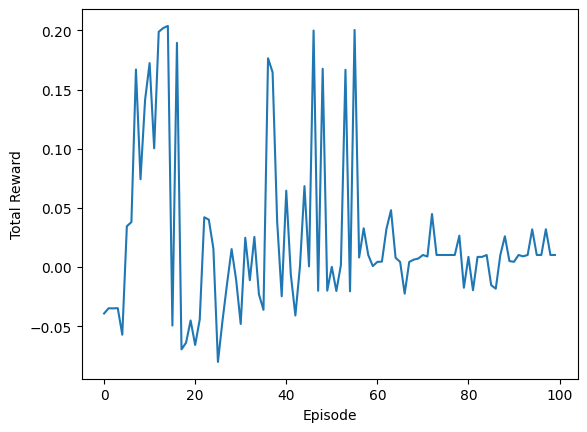

In [10]:
# Define the exploration rate
epsilon = 0.1

# Modify the exploration phase of Q-learning to include the battery capacity in terms of watt hours
total_rewards = []  # list to store the total reward in each episode

for _ in range(num_iterations):

    # Select a random state
    state = random.choice(list(Q_table.keys()))
    
    # Initialize total reward for this episode
    total_reward = 0
    battery_state = initial_battery_state  # reset the battery state at the start of each 
    
    for timestamp in range(timepoints):  # 8 time steps (15 minutes each) in a 24-hour period
        
        # Update the state based on the current timestamp
        state = get_state(df2['cost'][timestamp], df2['demand'][timestamp], timestamp, battery_state)
   
        # Select an action
        if random.uniform(0, 1) < epsilon:
            # Exploration: select a random action
            action = random.choice(actions)
        else:
            # Exploitation: select the best action
            action = get_best_action(state)
        # Calculate the reward for the action
        reward = get_reward(state, action)
        total_reward += reward  # add the reward to the total reward for this episode
        # Update the battery capacity based on the action
        if action == 'charge':
            battery_state = min(battery_state + charge_discharge_rate, battery_capacity)
        elif action == 'discharge':
            battery_state = max(battery_state - charge_discharge_rate, 0)
        # Update the Q-value for the state-action pair
        Q_table[state][action] = (1 - alpha) * Q_table[state][action] + alpha * (reward + gamma * max(Q_table[state].values()))
    total_rewards.append(total_reward)  # store the total reward for this episode

# Plot the total reward in each episode
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

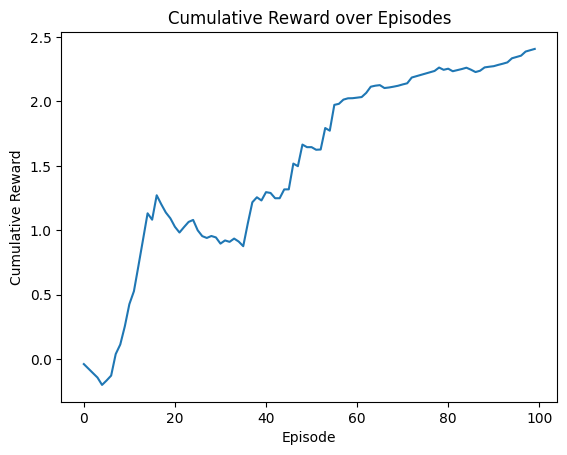

In [11]:
# Calculate the cumulative reward for each episode
cumulative_rewards = np.cumsum(total_rewards)
# Plot the cumulative reward of each episode
plt.plot(cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Episodes')
plt.show()

In [12]:
# Print the final Q-table
#for state, actions in Q_table.items():
#    print(f'State: {state}')
#    for action, Q_value in actions.items():
#        print(f'    Action: {action}, Q-value: {Q_value}')